## John Hoff  
# CSC 578 - 701 -- Homework #6
### 11/10/2019

_This is a third (C) attempt at the homework assignment to try a few different architecture strategies for the experiment.  This notebook is based directly from the (B) submission to take agantage of the automation put in place for parameter tuning._

## Python Imports and Setup
Some initial configurations are made to ignore warnings and set the log levels.  The notebook gets extremely verbose without this step. The following modules should be installed locally to run this notebook.
```
pip install tensorflow==1.14.0
pip install keras
pip install hyperopt
pip install matplotlib
pip install pandas
pip install scikit-optimize
```

In [1]:
# Suppress warnings generated by numpy and scikit-learn
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Suppress warnings based on future tensor flow deprecations.  Please note that this block does
# import tensorflow itself.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The remaining inputs are organized alphabetically.

In [2]:
from IPython.display import clear_output

import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

import matplotlib.pyplot as plt
plt.set_cmap("viridis")

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style="whitegrid")

from skopt import dump
from skopt import gp_minimize
from skopt import load
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective
from skopt.space import Categorical
from skopt.space import Integer
from skopt.space import Real

import time

Using TensorFlow backend.
c:\repos\depaul\csc578\venv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Prepare the Training Data
First all of the data is loaded for cifar10.  The `y_test` is immediately thrown out so that we don't accidentally leak the information into the resulting network training.

In [3]:
(x_training, y_training), (x_test, y_test) = cifar10.load_data()
y_test = []
num_classes = 10

The initial base model is going to make explicit use of training and testing splitting.

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x_training, y_training,
                                                      stratify=y_training, 
                                                      test_size=0.2)

y_train_bin = keras.utils.to_categorical(y_train, num_classes)
y_valid_bin = keras.utils.to_categorical(y_valid, num_classes)

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

Hyperparameter optimization and final model tuning will make use of the entire dataset.

In [5]:
y_training_bin = keras.utils.to_categorical(y_training, num_classes)
x_training = x_training.astype('float32')
x_training /= 255

## Create the Base Model for the Classification
This creates a base model with the following architecture:
1. Convolution -- 32 5x5 filters, stride (1,1), activation relu
2. Max pooling -- size 2x2, stride (2,2)
3. Convolution -- 32 5x5 filters, stride (1,1), activation relu
4. Max pooling -- size 2x2, stride (2,2)
5. Fully connected (Dense) -- 512 nodes, activation relu
6. Fully connected (Dense) -- 10 nodes, activation softmax

The summary of the model does look different from the example listed in the homework, but only due to how the network is actually constructed.  The number of parameters matches.

In [6]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)              

The base model is then trained and the test loss is displayed.

In [7]:
model.fit(x_train, y_train_bin, batch_size=100, epochs=25, validation_data=(x_valid, y_valid_bin))
test_loss = model.evaluate(x_valid, y_valid_bin, verbose=2)
print('Test Loss:', test_loss)

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 7s 167us/step - loss: 1.5733 - val_loss: 1.4175
Epoch 2/25
40000/40000 [==============================] - 5s 130us/step - loss: 1.2281 - val_loss: 1.2447
Epoch 3/25
40000/40000 [==============================] - 5s 132us/step - loss: 1.0915 - val_loss: 1.1076
Epoch 4/25
40000/40000 [==============================] - 5s 134us/step - loss: 0.9793 - val_loss: 1.0112
Epoch 5/25
40000/40000 [==============================] - 5s 131us/step - loss: 0.8724 - val_loss: 1.0085
Epoch 6/25
40000/40000 [==============================] - 5s 128us/step - loss: 0.8014 - val_loss: 0.9713
Epoch 7/25
40000/40000 [==============================] - 5s 128us/step - loss: 0.7219 - val_loss: 0.9924
Epoch 8/25
40000/40000 [==============================] - 5s 128us/step - loss: 0.6409 - val_loss: 0.9916
Epoch 9/25
40000/40000 [==============================] - 5s 127us/step - loss: 0.5609 - val_loss: 0.9

Predictions are then made so that they can be submitted over to kaggle.

In [8]:
predictions = model.predict(x_test)
predictions_df = pd.DataFrame(predictions, columns=['cat0' ,'cat1', 'cat2', 'cat3', 'cat4',
                                                    'cat5', 'cat6', 'cat7', 'cat8', 'cat9'])
predictions_df.index = np.arange(1, len(predictions_df) + 1)
display(predictions_df)
predictions_df.to_csv('base_submission_c.csv', index_label='id')

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
1,5.636973e-12,3.847810e-11,2.531331e-08,9.999946e-01,1.195437e-13,5.014570e-06,3.340734e-07,2.097291e-12,4.334688e-09,3.869399e-13
2,8.849414e-07,2.251332e-04,3.095185e-16,2.220692e-11,4.523555e-19,9.036126e-19,3.188604e-16,2.773677e-19,9.997671e-01,6.886087e-06
3,5.806744e-01,1.640566e-01,2.864225e-08,1.932046e-04,2.654411e-05,7.151400e-05,6.804241e-07,7.655667e-05,2.428878e-01,1.201263e-02
4,8.888939e-01,5.487301e-06,6.358895e-08,2.370093e-05,2.440286e-03,6.553074e-14,2.658289e-13,2.125910e-10,1.086353e-01,1.299777e-06
5,8.341663e-19,1.809258e-16,1.805748e-04,2.001241e-04,9.958497e-01,1.698651e-10,3.769513e-03,1.923189e-19,3.913734e-18,8.471174e-21
...,...,...,...,...,...,...,...,...,...,...
9996,4.318525e-10,5.155804e-15,5.594160e-15,6.457605e-01,9.846854e-06,6.836714e-05,7.900534e-06,3.664322e-14,3.541534e-01,3.156107e-15
9997,5.443147e-13,3.368422e-12,1.102556e-05,8.773457e-01,4.307935e-03,1.522068e-03,1.167540e-01,5.931935e-05,9.681209e-19,5.369282e-11
9998,3.805056e-24,6.407763e-23,3.285032e-05,1.150450e-10,7.195071e-17,9.999666e-01,1.211502e-11,5.034293e-07,7.789231e-24,7.423083e-21
9999,5.287618e-06,1.143936e-05,1.983801e-04,7.331614e-01,2.647502e-01,9.733438e-11,1.873390e-03,2.582879e-12,6.008785e-13,3.906581e-11


## Create a Configurable Model
The following model is configurable based on a set of dimensions. These dimensions are not controlling the architecture itself, but the underlying learning parameters.

In [9]:
default_dimensions = [
    15,     # rotation
    0.150,  # shift
    0.100,  # dropout
    0.001,  # learning_rate
    0.900,  # beta_1
    0.999,  # beta_2
]

def train_network(dimensions, x, y, x_validation=None, y_validation=None, epochs=1):
    rotation, shift, dropout, learning_rate, beta_1, beta_2 = dimensions
    
    # The training data is being augmented to dramatically increase the training data and
    # hopefully decrease overfitting and improve generalization
    augmentation = ImageDataGenerator(
        rotation_range=rotation,
        width_shift_range=shift,
        height_shift_range=shift,
        zoom_range=shift,
        channel_shift_range=shift,
        horizontal_flip=True,
    )
    augmentation.fit(x)
    
    # The CNN here is double-stacked 3x3 convolutions.
    cnn_input = Input(shape=x.shape[1:])
    
    cnn_3x3 = Conv2D(64, 3, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4))(cnn_input)
    cnn_3x3 = Activation('elu')(cnn_3x3)
    cnn_3x3 = Conv2D(64, 3, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4))(cnn_3x3)
    cnn_3x3 = Activation('elu')(cnn_3x3)
    cnn_3x3 = MaxPooling2D(padding='same')(cnn_3x3)
    
    cnn_3x3 = Conv2D(64, 3, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4))(cnn_3x3)
    cnn_3x3 = Activation('elu')(cnn_3x3)
    cnn_3x3 = Conv2D(64, 3, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4))(cnn_3x3)
    cnn_3x3 = Activation('elu')(cnn_3x3)
    cnn_3x3 = MaxPooling2D(padding='same')(cnn_3x3)
    
    cnn_3x3 = Conv2D(64, 3, padding='same',
                     input_shape=x_train.shape[1:],
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4))(cnn_3x3)
    cnn_3x3 = Activation('elu')(cnn_3x3)
    cnn_3x3 = Conv2D(64, 3, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4))(cnn_3x3)
    cnn_3x3 = Activation('elu')(cnn_3x3)
    cnn_3x3 = MaxPooling2D(padding='same')(cnn_3x3)
    
    cnn_3x3 = Flatten()(cnn_3x3)
    
    # Two fully connected layers are added
    fc = Dense(1024, kernel_initializer='he_uniform')(cnn_3x3)
    fc = Activation('sigmoid')(fc)
    fc = Dropout(dropout)(fc)
    
    fc = Dense(512, kernel_initializer='he_uniform')(fc)
    fc = Activation('sigmoid')(fc)
    fc = Dropout(dropout)(fc)
    
    # The output of the model is fixed.
    fc = Dense(num_classes, kernel_initializer='he_uniform')(fc)
    fc = Activation('softmax')(fc)
    
    # The model is constructed in a functional style from the input and output.
    model = Model(inputs=[cnn_input], outputs=[fc])
    
    # Compiling the model with Nadam allows for tuning the individual learning parameters.
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate,
                                                  beta_1=beta_1, beta_2=beta_2),
                  loss='categorical_crossentropy')
    
    # If validation data is being passed in, that will be used to evaluate the model.  Otherwise,
    # it will simply train on all of the data and return.
    if x_validation is not None and y_validation is not None:
        model.fit_generator(augmentation.flow(x, y, batch_size=100), epochs=epochs, shuffle=True,
                            validation_data=(x_validation, y_validation))
        loss = model.evaluate(x_validation, y_validation)
        return model, loss
    else:
        model.fit_generator(augmentation.flow(x, y, batch_size=100), epochs=epochs, shuffle=True)
        loss = model.evaluate(x, y)
        return model, loss

A network will then be trained to test everything out.  This gives a good benchmark to begin testing from.

In [10]:
default_model, default_loss = train_network(default_dimensions,
                                            x_train, y_train_bin,
                                            x_valid, y_valid_bin,
                                            epochs=25)

Epoch 1/25
400/400 [==============================] - 23s 57ms/step - loss: 1.8105 - val_loss: 1.2982
Epoch 2/25
400/400 [==============================] - 22s 55ms/step - loss: 1.3324 - val_loss: 1.0993
Epoch 3/25
400/400 [==============================] - 22s 55ms/step - loss: 1.1469 - val_loss: 0.9775
Epoch 4/25
400/400 [==============================] - 22s 55ms/step - loss: 1.0310 - val_loss: 1.0314
Epoch 5/25
400/400 [==============================] - 22s 55ms/step - loss: 0.9602 - val_loss: 0.8580
Epoch 6/25
400/400 [==============================] - 22s 55ms/step - loss: 0.9086 - val_loss: 0.8348
Epoch 7/25
400/400 [==============================] - 22s 55ms/step - loss: 0.8700 - val_loss: 0.7502
Epoch 8/25
400/400 [==============================] - 22s 55ms/step - loss: 0.8286 - val_loss: 0.7685
Epoch 9/25
400/400 [==============================] - 22s 55ms/step - loss: 0.8001 - val_loss: 0.7483
Epoch 10/25
400/400 [==============================] - 22s 55ms/step - loss: 0.787

The following network architecture is now effectively frozen for subsequent optimizations.

In [11]:
default_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        3692

A benchmark set of predictions are also created so that we can measure the actual impact of the hyperparameter optimizations.

In [12]:
predictions = default_model.predict(x_test)
predictions_df = pd.DataFrame(predictions, columns=['cat0' ,'cat1', 'cat2', 'cat3', 'cat4',
                                                    'cat5', 'cat6', 'cat7', 'cat8', 'cat9'])
predictions_df.index = np.arange(1, len(predictions_df) + 1)
display(predictions_df)
predictions_df.to_csv('default_submission_c.csv', index_label='id')

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
1,0.000375,2.887111e-03,0.013935,0.837643,0.001115,0.116047,0.022989,0.002838,1.193635e-03,9.772433e-04
2,0.000643,2.452683e-02,0.000040,0.000021,0.000002,0.000012,0.000013,0.000009,9.714053e-01,3.327637e-03
3,0.008416,6.923590e-01,0.000110,0.000101,0.000050,0.000045,0.000106,0.000056,2.568693e-01,4.188796e-02
4,0.146707,1.138869e-01,0.001045,0.000829,0.000135,0.000053,0.000787,0.000044,5.933214e-01,1.431909e-01
5,0.000412,6.795422e-04,0.026017,0.005957,0.033885,0.000311,0.930022,0.000087,2.444247e-03,1.855546e-04
...,...,...,...,...,...,...,...,...,...,...
9996,0.048529,2.430340e-02,0.009480,0.122962,0.003524,0.016666,0.012913,0.007676,7.499917e-01,3.954003e-03
9997,0.000051,7.304320e-04,0.009107,0.427701,0.021975,0.024014,0.510947,0.003620,1.112583e-04,1.742055e-03
9998,0.000035,9.763607e-06,0.004208,0.010055,0.000969,0.977410,0.002354,0.004681,3.717019e-05,2.406784e-04
9999,0.004622,9.844924e-01,0.000827,0.000133,0.000489,0.000084,0.000637,0.000038,3.934532e-03,4.744079e-03


## Searching for an Optimal Model
Now that the architecture is set, we are going to define a dimension space based on the default demensions that have been defined for the network.

In [13]:
dimensions = [
    Integer(low=0, high=30, name='rotation'),
    Real(low=0.00, high=0.25, name='shift'),
    Real(low=0.0, high=0.5, name='dropout'),
    Real(low=1e-5, high=1e-2, prior='log-uniform', name='learning_rate'),
    Real(low=0.3, high=0.9, name='beta_1'),
    Real(low=0.333, high=0.999, name='beta_2'),
]

dimension_labels = list()
for dimension in dimensions:
    dimension_labels.append(dimension.name)

I am only going to be doing 11 iterations at a time.  10 is the minimum number of iterations available when using `gp_minimize()` and we need to add one extra due to passing in defaults for the first experiment.  Everything is being set up so that the search space is re-entrant and can be run far more than 11 times.

In [14]:
iterations_current = 1
iterations_max = 11
search_start_time = time.time()

The following functions define the "objective function" that the gaussian process will be evaluating.  The `objective_function` performs the necessary bookkeeping for the searching.  It also will perform a train/test split for each search iteration.

In [15]:
def objective_function(dimensions):
    global iterations_current
    global iterations_max
    global search_start_time
    global dimension_labels
    global x_training
    global y_training
    global num_classes
    
    # Reporting on progress is given in a manner that will minimize the overall spam
    # being sent to the user session.  It will show progress, elapsed time, and give
    # a super rough estimated remaining time.
    clear_output()
    elapsed_time = time.time() - search_start_time
    if iterations_current == 1:
        estimated_time = 0
    else:
        estimated_time = (elapsed_time / (iterations_current - 1)) * iterations_max - elapsed_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    estimated_time_str = time.strftime("%H:%M:%S", time.gmtime(estimated_time))
    print('Iteration %s of %s (Running: %s, Remaining: %s)'
          % (iterations_current, iterations_max, elapsed_time_str, estimated_time_str))
    for i in range(len(dimensions)):
        print('%s = %s' % (dimension_labels[i], dimensions[i]))
    
    # In the interest of time, cross-validation is not being performed.  A single
    # training, testing split is being created and run through the model
    X_train, X_test, Y_train, Y_test = train_test_split(x_training, y_training,
                                                      stratify=y_training, 
                                                      test_size=0.25)
    
    Y_train_bin = keras.utils.to_categorical(Y_train, num_classes)
    Y_test_bin = keras.utils.to_categorical(Y_test, num_classes)
    
    model, loss = train_network(dimensions, X_train, Y_train_bin, X_test, Y_test_bin, 25)
    
    # Delete the model as it is no longer needed.
    del model
    keras.backend.clear_session()
    
    iterations_current += 1
    
    # The loss is returned.  This is the metric that we are optimizizing
    return loss

With the objective function and training function defined, I am going to establish the initial search parameters and checkpoint mechanism.  This allows for the search to pick back up where it left off.

In [23]:
# Create an initial class to checkpoint the results as everything is searched.
class CheckpointSaver(object):
    def __init__(self, checkpoint_path, **dump_options):
        self.checkpoint_path = checkpoint_path
        self.dump_options = dump_options

    def __call__(self, res):
        dump(res, self.checkpoint_path, **self.dump_options)
        global search_result
        search_result = res
checkpoint_callback = CheckpointSaver("search_result_c.pkl")

# Provide a relatively performant starting point
x0 = default_dimensions
y0 = None

# Override the starting point if we have previously saved results.
if os.path.exists('search_result_c.pkl'):
    print("Loading Checkpoint!")
    search_result = load('search_result_c.pkl')
    x0 = search_result.x_iters
    y0 = search_result.func_vals

Loading Checkpoint!


With all of that setup, I now have a fully re-entrant search function.  At any point in time, I can stop the notebook execution and the `search_result` will contain everything up to the last completed iteration.  This is very useful for not only being able to quickly test the starting point, but for having the ability keep searching for further improvements.  Please note that the output for the next cell will only show the most recent search iteration.  This was done to keep the notebook from getting overly large as more and more search iterations are performed.

In [24]:
search_start_time = time.time()
iterations_current = 1

search_result = gp_minimize(func=objective_function,
                            dimensions=dimensions,
                            callback=[checkpoint_callback],
                            x0=x0,
                            y0=y0,
                            n_calls=iterations_max)

Iteration 11 of 11 (Running: 01:33:47, Remaining: 00:09:22)
rotation = 27
shift = 0.07699250841854632
dropout = 0.18752210948467182
learning_rate = 0.0006931037041768425
beta_1 = 0.8815653454318164
beta_2 = 0.9989999999999999
Epoch 1/25
375/375 [==============================] - 22s 59ms/step - loss: 1.7385 - val_loss: 1.3606
Epoch 2/25
375/375 [==============================] - 22s 58ms/step - loss: 1.3133 - val_loss: 1.0974
Epoch 3/25
375/375 [==============================] - 22s 58ms/step - loss: 1.1414 - val_loss: 0.9779
Epoch 4/25
375/375 [==============================] - 22s 58ms/step - loss: 1.0352 - val_loss: 0.8693
Epoch 5/25
375/375 [==============================] - 22s 58ms/step - loss: 0.9694 - val_loss: 0.8607
Epoch 6/25
375/375 [==============================] - 22s 58ms/step - loss: 0.9060 - val_loss: 0.8199
Epoch 7/25
375/375 [==============================] - 22s 58ms/step - loss: 0.8659 - val_loss: 0.8198
Epoch 8/25
375/375 [==============================] - 22s 58

The hyperparameter search space can be quickly displayed on a Pandas dataframe.

In [25]:
results_df = pd.concat([
    pd.DataFrame(search_result.func_vals, columns=['Loss']),
    pd.DataFrame(search_result.x_iters, columns=dimension_labels)
], axis=1).sort_values('Loss')
pd.options.display.max_rows = 999
display(results_df)

,Loss,rotation,shift,dropout,learning_rate,beta_1,beta_2
30,0.592286,23,0.096817,0.262577,0.000747,0.878674,0.999000
23,0.608173,14,0.140383,0.236414,0.000664,0.636655,0.944817
74,0.635954,27,0.076993,0.187522,0.000693,0.881565,0.999000
41,0.641890,26,0.000000,0.173957,0.000705,0.900000,0.999000
72,0.669388,17,0.042545,0.125477,0.000391,0.644553,0.911267
73,0.671544,16,0.051219,0.327005,0.000344,0.762119,0.548005
3,0.676949,12,0.130296,0.435583,0.000548,0.713644,0.763237
52,0.678696,18,0.154531,0.222771,0.000292,0.900000,0.999000
55,0.686530,2,0.152634,0.235674,0.000348,0.344928,0.856641
62,0.698875,20,0.032154,0.287403,0.000169,0.876445,0.690955


As that isn't the most readable table, I am also just printing out the best parameters found.

In [26]:
best_parameters = pd.DataFrame(search_result.x, columns=['value'])
best_parameters.index = dimension_labels
display(best_parameters)

,value
rotation,23.000000
shift,0.096817
dropout,0.262577
learning_rate,0.000747
beta_1,0.878674
beta_2,0.999000


## Training an Optimized Model
The hyperparameters with the best loss score will now be used to train the model itself.  This will be much faster than the actual parameter searching.  I have adjusted these parameters to include the shift from preivous assignments.  I believe there is some additional tuning that would need to be performed to make everything work as expected.  Without the shift, the model will simply massively overfit.

In [27]:
model, loss = train_network(search_result.x, x_training, y_training_bin, epochs=200)

Epoch 1/200
500/500 [==============================] - 27s 54ms/step - loss: 1.6787
Epoch 2/200
500/500 [==============================] - 27s 54ms/step - loss: 1.2229
Epoch 3/200
500/500 [==============================] - 27s 54ms/step - loss: 1.0671
Epoch 4/200
500/500 [==============================] - 27s 54ms/step - loss: 0.9723
Epoch 5/200
500/500 [==============================] - 27s 54ms/step - loss: 0.9025
Epoch 6/200
500/500 [==============================] - 27s 54ms/step - loss: 0.8569
Epoch 7/200
500/500 [==============================] - 27s 54ms/step - loss: 0.8178
Epoch 8/200
500/500 [==============================] - 27s 54ms/step - loss: 0.7848
Epoch 9/200
500/500 [==============================] - 27s 54ms/step - loss: 0.7595
Epoch 10/200
500/500 [==============================] - 27s 54ms/step - loss: 0.7412
Epoch 11/200
500/500 [==============================] - 27s 54ms/step - loss: 0.7308
Epoch 12/200
500/500 [==============================] - 27s 54ms/step - lo

500/500 [==============================] - 27s 54ms/step - loss: 0.5322
Epoch 98/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5348
Epoch 99/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5363
Epoch 100/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5303
Epoch 101/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5223
Epoch 102/200
500/500 [==============================] - 27s 53ms/step - loss: 0.5284
Epoch 103/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5289
Epoch 104/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5362
Epoch 105/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5318
Epoch 106/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5396
Epoch 107/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5361
Epoch 108/200
500/500 [==============================] - 27s 54ms/step

500/500 [==============================] - 27s 54ms/step - loss: 0.5552
Epoch 193/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5658
Epoch 194/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5456
Epoch 195/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5535
Epoch 196/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5581
Epoch 197/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5544
Epoch 198/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5569
Epoch 199/200
500/500 [==============================] - 27s 54ms/step - loss: 0.5606
Epoch 200/200
50000/50000 [==============================] - 10s 208us/step


With the model trained, the predictions for the Kaggle submission file can be created.

In [28]:
predictions = model.predict(x_test)
predictions_df = pd.DataFrame(predictions, columns=['cat0' ,'cat1', 'cat2', 'cat3', 'cat4',
                                                    'cat5', 'cat6', 'cat7', 'cat8', 'cat9'])
predictions_df.index = np.arange(1, len(predictions_df) + 1)
display(predictions_df)
predictions_df.to_csv('submission_c.csv', index_label='id')

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
1,1.773396e-05,1.582496e-04,1.958127e-04,9.781142e-01,0.000369,0.012294,8.225828e-03,1.161416e-04,3.781824e-04,1.305584e-04
2,3.050124e-04,5.883189e-02,4.651557e-06,6.192913e-06,0.000002,0.000003,1.919774e-06,3.869197e-07,9.361956e-01,4.648821e-03
3,8.624356e-03,5.148977e-03,3.791674e-05,1.711209e-05,0.000021,0.000013,1.832060e-06,1.613032e-06,9.858173e-01,3.172953e-04
4,1.557935e-01,1.018026e-01,1.539096e-04,2.180662e-04,0.000024,0.000016,1.788565e-05,3.930268e-06,6.303777e-01,1.115924e-01
5,7.451832e-07,2.895240e-06,5.199554e-04,9.361475e-04,0.000505,0.000006,9.980265e-01,8.856578e-08,5.055500e-07,2.254944e-06
...,...,...,...,...,...,...,...,...,...,...
9996,1.195976e-03,2.121698e-04,1.213803e-04,3.069066e-03,0.000132,0.000358,3.707973e-04,4.537678e-04,9.936258e-01,4.609677e-04
9997,1.622600e-05,3.428410e-05,3.913393e-03,4.824637e-01,0.028551,0.002410,4.732866e-01,4.594345e-03,6.831675e-05,4.661975e-03
9998,1.711736e-07,8.388500e-07,2.602961e-04,5.984635e-04,0.000010,0.998995,5.776317e-05,7.493089e-05,6.784409e-07,1.337545e-06
9999,3.223931e-03,9.944760e-01,2.644713e-04,3.755001e-05,0.000134,0.000050,9.974393e-05,5.093166e-06,3.254423e-04,1.383369e-03


## Visualizaing the Hyperparameter Search Space
Given the improvements of the model by tuning the hyperparameters, it is important to understand the high dimensional space to see how the parameters impacted the model training and testing.

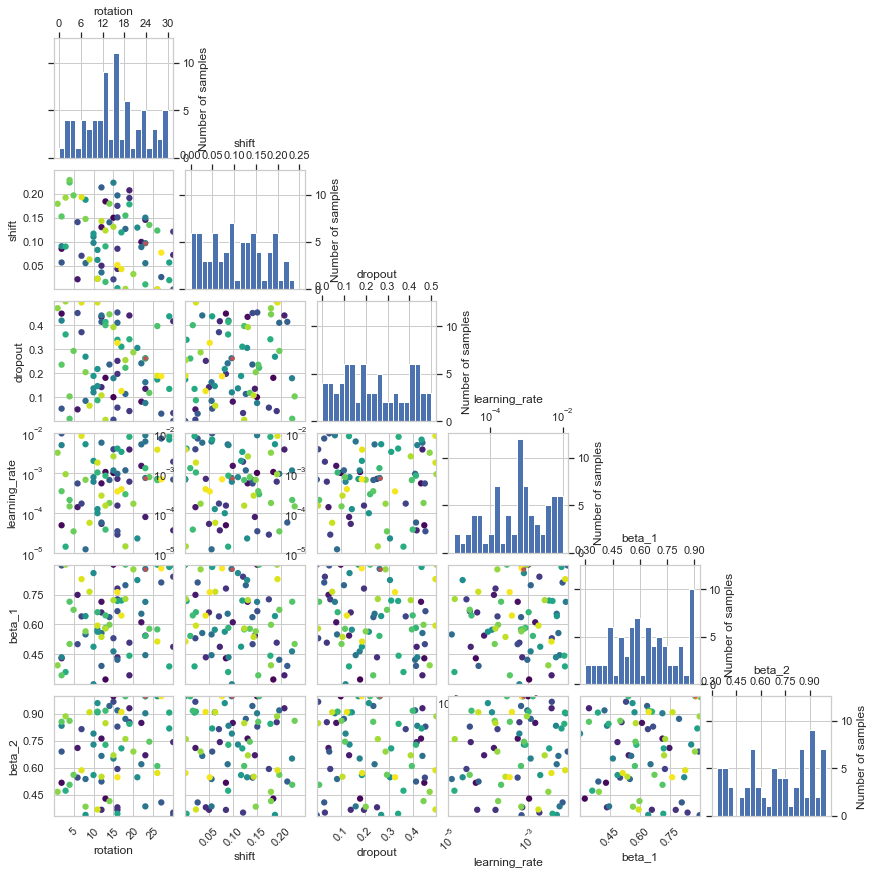

In [29]:
_ = plot_evaluations(search_result, dimensions=dimension_labels)

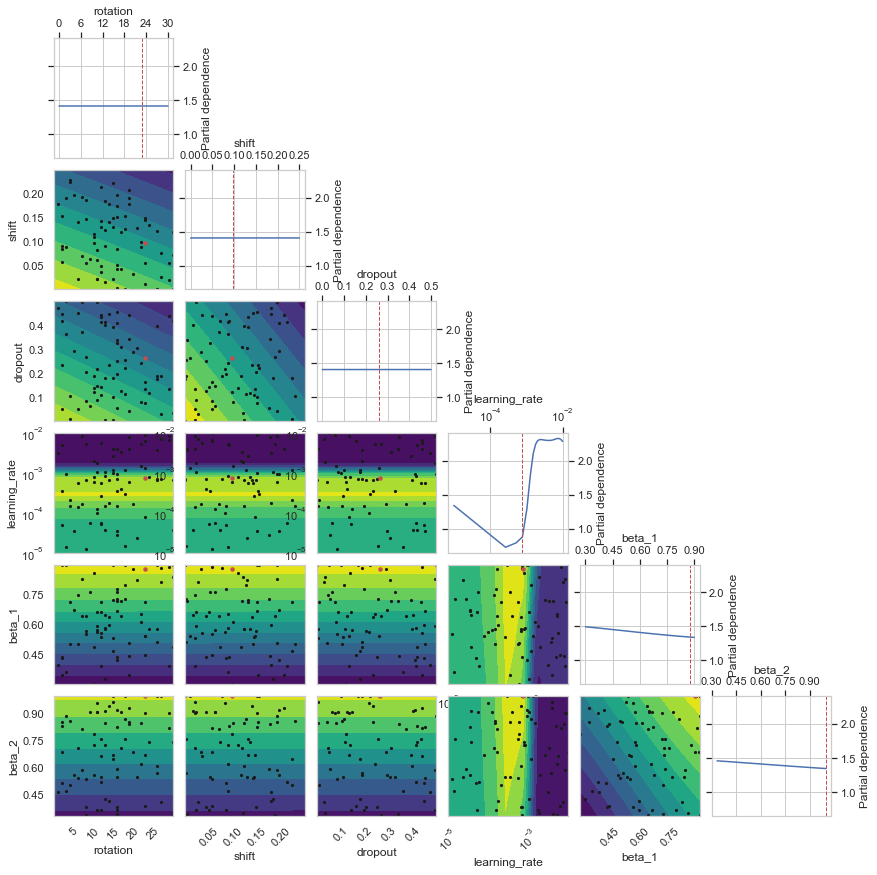

In [30]:
_ = plot_objective(search_result, dimensions=dimension_labels)